In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D,BatchNormalization, LSTM, CuDNNLSTM, MaxPooling2D
from keras.models import Sequential
from keras import regularizers
import keras

In [6]:
from keras.layers import TimeDistributed
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2

In [7]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [8]:
import os
from PIL import Image
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage import feature
import dlib

In [9]:
basemodel = tf.keras.models.Sequential()

In [10]:

basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(64,(5,5),activation='relu', input_shape = (48,48,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
                                        tf.keras.layers.AveragePooling2D(2,2),
                                        #tf.keras.layers.Dropout(0.25),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                        #tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
                                        tf.keras.layers.AveragePooling2D(2,2),
                                        tf.keras.layers.BatchNormalization(),
                                        #tf.keras.layers.Dropout(0.25),
                                        #
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(1024, activation='relu'),
                                        tf.keras.layers.Dropout(0.2),
                                        tf.keras.layers.Dense(7, activation='softmax')
                                       ])

In [11]:
basemodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 44, 44, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 64)        36928     
                                                                 
 average_pooling2d (AverageP  (None, 10, 10, 64)       0         
 ooling2D)                                                       
                                                                 
 batch_normalization (BatchN  (None, 10, 10, 64)       256       
 ormalization)                                                   
                                                      

In [12]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.0001, decay=1e-6),
                 loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [13]:
file_name = 'best_model.h5'
checkpoint_path = os.path.join('checkpoint',file_name)
call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                               monitor='val_accuracy',
                                               verbose=1,
                                               save_freq='epoch',
                                               save_best_only=True,
                                               save_weights_only=False,
                                               mode='max')

In [14]:
# Define emotion labels corresponding to subdirectories
emotion_labels = {'angry':0, 'disgust':1, 'fear':2, 'happy':3, 'neutral':4, 'sad':5, 'surprise':6}
# Define a mapping dictionary from numeric labels to emotion names
emotion_names = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

In [15]:
# Define the root directory where the fer2013 dataset images are stored
# Adjust the path to the actual dataset directory
dataset_dir = './FER-2013/'

In [16]:
# Initialize empty lists to store image data and labels
train_images = []
train_labels = []

In [17]:
# Iterate through subdirectories and load images and labels
for emotion, label in emotion_labels.items():
    subdirectory_path = os.path.join(dataset_dir, 'train',emotion)
    
    # Iterate through images in each subdirectory
    for image_filename in os.listdir(subdirectory_path):
        image_path = os.path.join(subdirectory_path, image_filename)
        
        # Open and preprocess the image (you may need to resize or convert to grayscale)
        image = cv2.imread(image_path)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Append the image and its label to the lists
        image = np.array(image)  # Convert to NumPy array if needed
        train_images.append(image)
        train_labels.append(label)  # Convert emotion label to integer 

In [18]:
# Convert lists to NumPy arrays for further processing
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_samples = len(train_images)

# Check the shapes of the arrays
print("Images shape:", train_images.shape)
print("Labels shape:", train_labels.shape)

Images shape: (28709, 48, 48)
Labels shape: (28709,)


In [19]:
train_images[0].shape

(48, 48)

In [20]:
count = [0,0,0,0,0,0,0]
for i in range(train_samples):
    count[train_labels[i]] = count[train_labels[i]] + 1
for i in range(7):
    print(count[i])

3995
436
4097
7215
4965
4830
3171


In [21]:
#from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
#X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [22]:
X_train = train_images/255

In [23]:
X_train.shape

(28709, 48, 48)

In [24]:
y_train = train_labels

In [25]:
basemodel.fit(X_train,y_train,epochs=20,validation_split=.1,callbacks=call_back)

Epoch 1/20
807/808 [============================>.] - ETA: 0s - loss: 1.5671 - accuracy: 0.3858
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to checkpoint\best_model.h5
808/808 [==============================] - 55s 64ms/step - loss: 1.5671 - accuracy: 0.3859 - val_loss: 5.2103 - val_accuracy: 0.0000e+00
Epoch 2/20
807/808 [============================>.] - ETA: 0s - loss: 1.3623 - accuracy: 0.4737
Epoch 2: val_accuracy improved from 0.00000 to 0.00070, saving model to checkpoint\best_model.h5
808/808 [==============================] - 52s 64ms/step - loss: 1.3623 - accuracy: 0.4738 - val_loss: 3.0858 - val_accuracy: 6.9662e-04
Epoch 3/20
807/808 [============================>.] - ETA: 0s - loss: 1.2371 - accuracy: 0.5257
Epoch 3: val_accuracy improved from 0.00070 to 0.00348, saving model to checkpoint\best_model.h5
808/808 [==============================] - 53s 66ms/step - loss: 1.2370 - accuracy: 0.5257 - val_loss: 3.1559 - val_accuracy: 0.0035
Epoch 4/20
807/80

In [26]:
# Initialize empty lists to store image data and labels
test_images = []
test_labels = []

In [27]:
# Iterate through subdirectories and load images and labels
for emotion, label in emotion_labels.items():
    subdirectory_path = os.path.join(dataset_dir, 'test', emotion)
    
    # Iterate through images in each subdirectory
    for image_filename in os.listdir(subdirectory_path):
        image_path = os.path.join(subdirectory_path, image_filename)
        
        img = Image.open(image_path)
        image = img.resize((48,48))
        # Open and preprocess the image (you may need to resize or convert to grayscale)
        #image = cv2.imread(image_path)
        
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Append the image and its label to the lists
        image = np.array(image)  # Convert to NumPy array if needed
        test_images.append(image)
        test_labels.append(label)  # Convert emotion label to integer

In [28]:
# Convert lists to NumPy arrays for further processing
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_samples = len(test_images)

# Check the shapes of the arrays
print("Images shape:", test_images.shape)
print("Labels shape:", test_labels.shape)

Images shape: (7178, 48, 48)
Labels shape: (7178,)


In [29]:
X_test = test_images/255

In [30]:
X_test.shape

(7178, 48, 48)

In [31]:
y_test = test_labels

In [32]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [33]:
y_pred_test = []
for i in range(7178):
    y_pred = basemodel.predict(tf.expand_dims(X_test[i], 0)).argmax()
    y_pred_test.append(y_pred)

1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 30ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 33ms/step


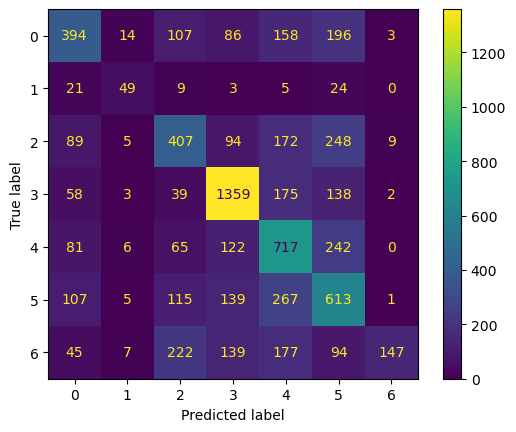

In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [37]:
# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred_test)
report = classification_report(y_test, y_pred_test)

print("Test Accuracy:", accuracy)
print("Classification Report:\n", report)

Test Accuracy: 0.5135135135135135
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.41      0.45       958
           1       0.55      0.44      0.49       111
           2       0.42      0.40      0.41      1024
           3       0.70      0.77      0.73      1774
           4       0.43      0.58      0.49      1233
           5       0.39      0.49      0.44      1247
           6       0.91      0.18      0.30       831

    accuracy                           0.51      7178
   macro avg       0.56      0.47      0.47      7178
weighted avg       0.56      0.51      0.50      7178

